# Shot Quality for Offensive Rebounding
#### Goal is to use location data to predict offensive rebouding probability

#### Aim to try different machine learning methods to see which method would work best for this application

### Importing Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_pbp = pd.read_csv("/kaggle/input/shotquality-rebounding/train_pbp.csv")
test_pbp = pd.read_csv("/kaggle/input/shotquality-rebounding/test_pbp.csv")
train_locs = pd.read_csv("/kaggle/input/shotquality-rebounding/train_locs.csv")
test_locs = pd.read_csv("/kaggle/input/shotquality-rebounding/test_locs.csv")

### Pre-Modelling

#### Data Cleaning
-Make sure that each possession is within bounds and has a shooter

In [91]:
wide_clean = train_locs.dropna()

wide_clean["has_Shooter"] = np.where(train_locs.groupby('id')['annotation_code'] != "s", 1, 0)

wide_clean["OOB"] = np.where(train_locs['court_y'] >= 50, 1, 0)

#### Feature Engineering

****-Distance to Rim

****-Distance to Shooter

****-Number of defenders/offense players within a radius of the rim
    ****-Advantage number +/-

****-Number of Offense/Defense within radius of shooter
    ****-Advantage number +/-

****-Average X/Y of offense/defense

****-Distance of shot
    -Rough Geographic Area of shot

****-Closest Defense distance to shooter

****-Rebound rate in game so far

In [19]:
train_locs["Offense"] = np.where(train_locs['annotation_code'].apply(lambda x: x[0]) == "d", 0 ,1)

##### Distance to Rim

In [20]:
train_locs["DistanceToRim"] = np.minimum(np.sqrt((train_locs['court_x'] - 4)**2 + (train_locs["court_y"] - 25)**2),
                                      np.sqrt((train_locs['court_x'] - 90)**2 + (train_locs["court_y"] - 25)**2))

In [21]:
train_locs["OffenseWithin2ofRim"] = np.where((train_locs['DistanceToRim'] <= 2) & (train_locs["Offense"] == 1), 1, 0)
train_locs["OffenseWithin5ofRim"] = np.where((train_locs['DistanceToRim'] <= 5) & (train_locs["Offense"] == 1), 1, 0)
train_locs["OffenseWithin10ofRim"] = np.where((train_locs['DistanceToRim'] <= 10) & (train_locs["Offense"] == 1), 1, 0)
train_locs["OffenseWithin15ofRim"] = np.where((train_locs['DistanceToRim'] <= 15) & (train_locs["Offense"] == 1), 1, 0)

train_locs = train_locs.assign(OffenseWithin2ofRim = train_locs.groupby('id')['OffenseWithin2ofRim'].transform(sum))
train_locs = train_locs.assign(OffenseWithin5ofRim = train_locs.groupby('id')['OffenseWithin5ofRim'].transform(sum))
train_locs = train_locs.assign(OffenseWithin10ofRim = train_locs.groupby('id')['OffenseWithin10ofRim'].transform(sum))
train_locs = train_locs.assign(OffenseWithin15ofRim = train_locs.groupby('id')['OffenseWithin15ofRim'].transform(sum))

In [22]:
train_locs["DefenseWithin2ofRim"] = np.where((train_locs['DistanceToRim'] <= 2) & (train_locs["Offense"] == 0), 1, 0)
train_locs["DefenseWithin5ofRim"] = np.where((train_locs['DistanceToRim'] <= 5) & (train_locs["Offense"] == 0), 1, 0)
train_locs["DefenseWithin10ofRim"] = np.where((train_locs['DistanceToRim'] <= 10) & (train_locs["Offense"] == 0), 1, 0)
train_locs["DefenseWithin15ofRim"] = np.where((train_locs['DistanceToRim'] <= 15) & (train_locs["Offense"] == 0), 1, 0)

train_locs = train_locs.assign(DefenseWithin2ofRim = train_locs.groupby('id')['DefenseWithin2ofRim'].transform(sum))
train_locs = train_locs.assign(DefenseWithin5ofRim = train_locs.groupby('id')['DefenseWithin5ofRim'].transform(sum))
train_locs = train_locs.assign(DefenseWithin10ofRim = train_locs.groupby('id')['DefenseWithin10ofRim'].transform(sum))
train_locs = train_locs.assign(DefenseWithin15ofRim = train_locs.groupby('id')['DefenseWithin15ofRim'].transform(sum))

##### Distance to Shooter/Shot

In [23]:
shooter_x = train_locs[train_locs['annotation_code'] == "s"][['id', 'court_x', 'court_y']]
shooter_x = shooter_x.rename(columns = {'court_x':"shooter_x", 'court_y':'shooter_y'})
train_locs = train_locs.merge(shooter_x, on = "id")

In [24]:
train_locs["DistanceToShooter"] = np.minimum(np.sqrt((train_locs['court_x'] - train_locs['shooter_x'])**2 + (train_locs["court_y"] - train_locs['shooter_y'])**2),
                                      np.sqrt((train_locs['court_x'] - train_locs['shooter_x'])**2 + (train_locs["court_y"] - train_locs['shooter_y'])**2))

train_locs["DistanceOfShot"] = np.minimum(np.sqrt((train_locs['shooter_x'] - 4)**2 + (train_locs["shooter_y"] - 25)**2),
                                      np.sqrt((train_locs['shooter_x'] - 90)**2 + (train_locs["shooter_y"] - 25)**2))

In [25]:
train_locs["OffenseWithin2ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 2) & (train_locs["Offense"] == 1), 1, 0)
train_locs["OffenseWithin5ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 5) & (train_locs["Offense"] == 1), 1, 0)
train_locs["OffenseWithin10ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 10) & (train_locs["Offense"] == 1), 1, 0)
train_locs["OffenseWithin15ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 15) & (train_locs["Offense"] == 1), 1, 0)

train_locs = train_locs.assign(OffenseWithin2ofShooter = train_locs.groupby('id')['OffenseWithin2ofShooter'].transform(sum))
train_locs = train_locs.assign(OffenseWithin5ofShooter = train_locs.groupby('id')['OffenseWithin5ofShooter'].transform(sum))
train_locs = train_locs.assign(OffenseWithin10ofShooter = train_locs.groupby('id')['OffenseWithin10ofShooter'].transform(sum))
train_locs = train_locs.assign(OffenseWithin15ofShooter = train_locs.groupby('id')['OffenseWithin15ofShooter'].transform(sum))

In [26]:
train_locs["DefenseWithin2ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 2) & (train_locs["Offense"] == 0), 1, 0)
train_locs["DefenseWithin5ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 5) & (train_locs["Offense"] == 0), 1, 0)
train_locs["DefenseWithin10ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 10) & (train_locs["Offense"] == 0), 1, 0)
train_locs["DefenseWithin15ofShooter"] = np.where((train_locs['DistanceToShooter'] <= 15) & (train_locs["Offense"] == 0), 1, 0)

train_locs = train_locs.assign(DefenseWithin2ofShooter = train_locs.groupby('id')['DefenseWithin2ofShooter'].transform(sum))
train_locs = train_locs.assign(DefenseWithin5ofShooter = train_locs.groupby('id')['DefenseWithin5ofShooter'].transform(sum))
train_locs = train_locs.assign(DefenseWithin10ofShooter = train_locs.groupby('id')['DefenseWithin10ofShooter'].transform(sum))
train_locs = train_locs.assign(DefenseWithin15ofShooter = train_locs.groupby('id')['DefenseWithin15ofShooter'].transform(sum))

In [27]:
train_locs = train_locs.assign(ClosestDefenderToShot = train_locs[train_locs['Offense'] == 0].groupby('id')['DistanceToShooter'].transform(min))

##### Average Offense/Defense Position and Advantage

In [28]:
train_locs = train_locs.assign(AverageOffenseX = train_locs[train_locs['Offense'] == 1].groupby('id')['court_x'].transform(np.mean),\
                               AverageOffenseY = train_locs[train_locs['Offense'] == 1].groupby('id')['court_y'].transform(np.mean),\
                                AverageDefenseX = train_locs[train_locs['Offense'] == 0].groupby('id')['court_x'].transform(np.mean),\
                                    AverageDefenseY = train_locs[train_locs['Offense'] == 0].groupby('id')['court_y'].transform(np.mean))

In [29]:
train_locs["AverageDefenseX"] = train_locs.groupby('id')["AverageDefenseX"].fillna(method = "ffill")
train_locs["AverageDefenseY"] = train_locs.groupby('id')["AverageDefenseY"].fillna(method = "ffill")
train_locs["ClosestDefenderToShot"] = train_locs.groupby('id')["ClosestDefenderToShot"].fillna(method = "ffill")

train_locs["AverageOffenseX"] = train_locs.groupby('id')["AverageOffenseX"].fillna(method = "bfill")
train_locs["AverageOffenseY"] = train_locs.groupby('id')["AverageOffenseY"].fillna(method = "bfill")

In [30]:
train_locs["OffenseAdvantage2ofRim"] = train_locs["OffenseWithin2ofRim"] - train_locs["DefenseWithin2ofRim"]
train_locs["OffenseAdvantage5ofRim"] = train_locs["OffenseWithin5ofRim"] - train_locs["DefenseWithin5ofRim"]
train_locs["OffenseAdvantage10ofRim"] = train_locs["OffenseWithin10ofRim"] - train_locs["DefenseWithin10ofRim"]
train_locs["OffenseAdvantage15ofRim"] = train_locs["OffenseWithin15ofRim"] - train_locs["DefenseWithin15ofRim"]



In [31]:
train_locs_by_id = train_locs.groupby('id').first().reset_index()

train_locs_by_id = train_locs_by_id.drop(columns = ["court_x", "court_y", "annotation_code", "DistanceToRim", "Offense", "DistanceToShooter", "shooter_x", "shooter_y"])

##### Getting the Current Rebound Rate

In [32]:
train_pbp["Game"] = train_pbp['id'].apply(lambda x: x.split('-')[0])
train_pbp["Play"] = train_pbp['id'].apply(lambda x: x.split('-')[1])

oreb = train_pbp.groupby("Game")["is_oreb"]

train_pbp["OffenseReboundRate"] = (oreb.cumsum() - train_pbp["is_oreb"])/oreb.cumcount()

train_pbp["OffenseReboundRate"] = train_pbp["OffenseReboundRate"].replace(np.nan, 0)


##### Making the Full Wide Data

Be able to have each row be a distinct shot, like in the pbp data, with a pair of x/y columns for each other player on that play.

This allows for more direct access in ML models.

In [33]:
train_locs_Xsplit = train_locs.pivot(index = 'id', columns = 'annotation_code', values = "court_x")
train_locs_Ysplit = train_locs.pivot(index = 'id', columns = 'annotation_code', values = 'court_y')
train_locs_wide = train_locs_Xsplit.merge(train_locs_Ysplit, left_on='id', right_on='id')

intFullWide = train_pbp.merge(train_locs_wide, left_on='id', right_on='id')
full_wide = intFullWide.merge(train_locs_by_id, left_on='id', right_on='id')


In [36]:
test_locs["Offense"] = np.where(test_locs['annotation_code'].apply(lambda x: x[0]) == "d", 0 ,1)
##### Distance to Rim
test_locs["DistanceToRim"] = np.minimum(np.sqrt((test_locs['court_x'] - 4)**2 + (test_locs["court_y"] - 25)**2),
                                      np.sqrt((test_locs['court_x'] - 90)**2 + (test_locs["court_y"] - 25)**2))
test_locs["OffenseWithin2ofRim"] = np.where((test_locs['DistanceToRim'] <= 2) & (test_locs["Offense"] == 1), 1, 0)
test_locs["OffenseWithin5ofRim"] = np.where((test_locs['DistanceToRim'] <= 5) & (test_locs["Offense"] == 1), 1, 0)
test_locs["OffenseWithin10ofRim"] = np.where((test_locs['DistanceToRim'] <= 10) & (test_locs["Offense"] == 1), 1, 0)
test_locs["OffenseWithin15ofRim"] = np.where((test_locs['DistanceToRim'] <= 15) & (test_locs["Offense"] == 1), 1, 0)

test_locs = test_locs.assign(OffenseWithin2ofRim = test_locs.groupby('id')['OffenseWithin2ofRim'].transform(sum))
test_locs = test_locs.assign(OffenseWithin5ofRim = test_locs.groupby('id')['OffenseWithin5ofRim'].transform(sum))
test_locs = test_locs.assign(OffenseWithin10ofRim = test_locs.groupby('id')['OffenseWithin10ofRim'].transform(sum))
test_locs = test_locs.assign(OffenseWithin15ofRim = test_locs.groupby('id')['OffenseWithin15ofRim'].transform(sum))
test_locs["DefenseWithin2ofRim"] = np.where((test_locs['DistanceToRim'] <= 2) & (test_locs["Offense"] == 0), 1, 0)
test_locs["DefenseWithin5ofRim"] = np.where((test_locs['DistanceToRim'] <= 5) & (test_locs["Offense"] == 0), 1, 0)
test_locs["DefenseWithin10ofRim"] = np.where((test_locs['DistanceToRim'] <= 10) & (test_locs["Offense"] == 0), 1, 0)
test_locs["DefenseWithin15ofRim"] = np.where((test_locs['DistanceToRim'] <= 15) & (test_locs["Offense"] == 0), 1, 0)

test_locs = test_locs.assign(DefenseWithin2ofRim = test_locs.groupby('id')['DefenseWithin2ofRim'].transform(sum))
test_locs = test_locs.assign(DefenseWithin5ofRim = test_locs.groupby('id')['DefenseWithin5ofRim'].transform(sum))
test_locs = test_locs.assign(DefenseWithin10ofRim = test_locs.groupby('id')['DefenseWithin10ofRim'].transform(sum))
test_locs = test_locs.assign(DefenseWithin15ofRim = test_locs.groupby('id')['DefenseWithin15ofRim'].transform(sum))
##### Distance to Shooter/Shot
shooter_x = test_locs[test_locs['annotation_code'] == "s"][['id', 'court_x', 'court_y']]
shooter_x = shooter_x.rename(columns = {'court_x':"shooter_x", 'court_y':'shooter_y'})
test_locs = test_locs.merge(shooter_x, on = "id")
test_locs["DistanceToShooter"] = np.minimum(np.sqrt((test_locs['court_x'] - test_locs['shooter_x'])**2 + (test_locs["court_y"] - test_locs['shooter_y'])**2),
                                      np.sqrt((test_locs['court_x'] - test_locs['shooter_x'])**2 + (test_locs["court_y"] - test_locs['shooter_y'])**2))

test_locs["DistanceOfShot"] = np.minimum(np.sqrt((test_locs['shooter_x'] - 4)**2 + (test_locs["shooter_y"] - 25)**2),
                                      np.sqrt((test_locs['shooter_x'] - 90)**2 + (test_locs["shooter_y"] - 25)**2))
test_locs["OffenseWithin2ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 2) & (test_locs["Offense"] == 1), 1, 0)
test_locs["OffenseWithin5ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 5) & (test_locs["Offense"] == 1), 1, 0)
test_locs["OffenseWithin10ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 10) & (test_locs["Offense"] == 1), 1, 0)
test_locs["OffenseWithin15ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 15) & (test_locs["Offense"] == 1), 1, 0)

test_locs = test_locs.assign(OffenseWithin2ofShooter = test_locs.groupby('id')['OffenseWithin2ofShooter'].transform(sum))
test_locs = test_locs.assign(OffenseWithin5ofShooter = test_locs.groupby('id')['OffenseWithin5ofShooter'].transform(sum))
test_locs = test_locs.assign(OffenseWithin10ofShooter = test_locs.groupby('id')['OffenseWithin10ofShooter'].transform(sum))
test_locs = test_locs.assign(OffenseWithin15ofShooter = test_locs.groupby('id')['OffenseWithin15ofShooter'].transform(sum))
test_locs["DefenseWithin2ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 2) & (test_locs["Offense"] == 0), 1, 0)
test_locs["DefenseWithin5ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 5) & (test_locs["Offense"] == 0), 1, 0)
test_locs["DefenseWithin10ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 10) & (test_locs["Offense"] == 0), 1, 0)
test_locs["DefenseWithin15ofShooter"] = np.where((test_locs['DistanceToShooter'] <= 15) & (test_locs["Offense"] == 0), 1, 0)

test_locs = test_locs.assign(DefenseWithin2ofShooter = test_locs.groupby('id')['DefenseWithin2ofShooter'].transform(sum))
test_locs = test_locs.assign(DefenseWithin5ofShooter = test_locs.groupby('id')['DefenseWithin5ofShooter'].transform(sum))
test_locs = test_locs.assign(DefenseWithin10ofShooter = test_locs.groupby('id')['DefenseWithin10ofShooter'].transform(sum))
test_locs = test_locs.assign(DefenseWithin15ofShooter = test_locs.groupby('id')['DefenseWithin15ofShooter'].transform(sum))
test_locs = test_locs.assign(ClosestDefenderToShot = test_locs[test_locs['Offense'] == 0].groupby('id')['DistanceToShooter'].transform(min))
##### Average Offense/Defense Position and Advantage
test_locs = test_locs.assign(AverageOffenseX = test_locs[test_locs['Offense'] == 1].groupby('id')['court_x'].transform(np.mean),\
                               AverageOffenseY = test_locs[test_locs['Offense'] == 1].groupby('id')['court_y'].transform(np.mean),\
                                AverageDefenseX = test_locs[test_locs['Offense'] == 0].groupby('id')['court_x'].transform(np.mean),\
                                    AverageDefenseY = test_locs[test_locs['Offense'] == 0].groupby('id')['court_y'].transform(np.mean))
test_locs["AverageDefenseX"] = test_locs.groupby('id')["AverageDefenseX"].fillna(method = "ffill")
test_locs["AverageDefenseY"] = test_locs.groupby('id')["AverageDefenseY"].fillna(method = "ffill")
test_locs["ClosestDefenderToShot"] = test_locs.groupby('id')["ClosestDefenderToShot"].fillna(method = "ffill")

test_locs["AverageOffenseX"] = test_locs.groupby('id')["AverageOffenseX"].fillna(method = "bfill")
test_locs["AverageOffenseY"] = test_locs.groupby('id')["AverageOffenseY"].fillna(method = "bfill")
test_locs["OffenseAdvantage2ofRim"] = test_locs["OffenseWithin2ofRim"] - test_locs["DefenseWithin2ofRim"]
test_locs["OffenseAdvantage5ofRim"] = test_locs["OffenseWithin5ofRim"] - test_locs["DefenseWithin5ofRim"]
test_locs["OffenseAdvantage10ofRim"] = test_locs["OffenseWithin10ofRim"] - test_locs["DefenseWithin10ofRim"]
test_locs["OffenseAdvantage15ofRim"] = test_locs["OffenseWithin15ofRim"] - test_locs["DefenseWithin15ofRim"]


test_locs_by_id = test_locs.groupby('id').first().reset_index()

test_locs_by_id = test_locs_by_id.drop(columns = ["court_x", "court_y", "annotation_code", "DistanceToRim", "Offense", "DistanceToShooter", "shooter_x", "shooter_y"])

##### Making the Full Wide Data
#Be able to have each row be a distinct shot, like in the pbp data, with a pair of x/y columns for each other player on that play.

#This allows for more direct access in ML models.
test_locs_Xsplit = test_locs.pivot(index = 'id', columns = 'annotation_code', values = "court_x")
test_locs_Ysplit = test_locs.pivot(index = 'id', columns = 'annotation_code', values = 'court_y')
test_locs_wide = test_locs_Xsplit.merge(test_locs_Ysplit, left_on='id', right_on='id')

intFullWide = test_pbp.merge(test_locs_wide, left_on='id', right_on='id')
full_wide_test = intFullWide.merge(test_locs_by_id, left_on='id', right_on='id')


#### Test/Train Split

It is time series based by game. Split up the games code and randomly split into train/test based on game number, not row index

In [466]:
game_ids = list(full_wide['Game'].unique())

random.seed(42)

train_index = random.sample(game_ids, int(4830 * 0.8))



train_x = full_wide[full_wide["Game"].apply(lambda x: x in train_index)].iloc[:, 8:]

train_y = full_wide[full_wide["Game"].apply(lambda x: x in train_index)]["is_oreb"]


test_x = full_wide[full_wide["Game"].apply(lambda x: x not in train_index)].iloc[:, 8:]

test_y = full_wide[full_wide["Game"].apply(lambda x: x not in train_index)]["is_oreb"]


In [39]:
#For the Real Submission
train_x = full_wide.iloc[:, 9:]

train_y = full_wide["is_oreb"]


test_x = full_wide_test.iloc[:, 5:]

#### Plotting to validate

In [455]:
plot_full = train_pbp.merge(train_locs)

In [457]:

import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
def create_ncaa_full_court(ax=None, three_line='mens', court_color='#dfbb85',
                           lw=3, lines_color='black', lines_alpha=0.5,
                           paint_fill='blue', paint_alpha=0.4,
                           inner_arc=False):
    """
    Version 2020.2.19
    Creates NCAA Basketball Court
    Dimensions are in feet (Court is 97x50 ft)
    Created by: Rob Mulla / https://github.com/RobMulla

    * Note that this function uses "feet" as the unit of measure.
    * NCAA Data is provided on a x range: 0, 100 and y-range 0 to 100
    * To plot X/Y positions first convert to feet like this:
    ```
    Events['X_'] = (Events['X'] * (94/100))
    Events['Y_'] = (Events['Y'] * (50/100))
    ```
    
    ax: matplotlib axes if None gets current axes using `plt.gca`


    three_line: 'mens', 'womens' or 'both' defines 3 point line plotted
    court_color : (hex) Color of the court
    lw : line width
    lines_color : Color of the lines
    lines_alpha : transparency of lines
    paint_fill : Color inside the paint
    paint_alpha : transparency of the "paint"
    inner_arc : paint the dotted inner arc
    """
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((94/2, 50/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
    hoop_left = Circle((5.25, 50/2), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)
    hoop_right = Circle((94-5.25, 50/2), 1.5 / 2,
                        linewidth=lw, color=lines_color, lw=lw,
                        fill=False, alpha=lines_alpha)

    # Paint - 18 Feet 10 inches which converts to 18.833333 feet - gross!
    left_paint = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    right_paint = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=paint_fill, alpha=paint_alpha,
                            lw=lw, edgecolor=None)
    
    left_paint_boarder = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=False, alpha=lines_alpha,
                           lw=lw, edgecolor=lines_color)
    right_paint_boarder = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=False, alpha=lines_alpha,
                            lw=lw, edgecolor=lines_color)

    left_arc = Arc((18.833333, 50/2), 12, 12, theta1=-
                   90, theta2=90, color=lines_color, lw=lw,
                   alpha=lines_alpha)
    right_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=90,
                    theta2=-90, color=lines_color, lw=lw,
                    alpha=lines_alpha)
    
    leftblock1 = Rectangle((7, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    leftblock2 = Rectangle((7, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(leftblock1)
    ax.add_patch(leftblock2)
    
    left_l1 = Rectangle((11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l2 = Rectangle((14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l3 = Rectangle((17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l1)
    ax.add_patch(left_l2)
    ax.add_patch(left_l3)
    left_l4 = Rectangle((11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l5 = Rectangle((14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l6 = Rectangle((17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l4)
    ax.add_patch(left_l5)
    ax.add_patch(left_l6)
    
    rightblock1 = Rectangle((94-7-1, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    rightblock2 = Rectangle((94-7-1, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(rightblock1)
    ax.add_patch(rightblock2)

    right_l1 = Rectangle((94-11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l2 = Rectangle((94-14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l3 = Rectangle((94-17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l1)
    ax.add_patch(right_l2)
    ax.add_patch(right_l3)
    right_l4 = Rectangle((94-11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l5 = Rectangle((94-14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l6 = Rectangle((94-17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l4)
    ax.add_patch(right_l5)
    ax.add_patch(right_l6)
    
    # 3 Point Line
    if (three_line == 'mens') | (three_line == 'both'):
        # 22' 1.75" distance to center of hoop
        three_pt_left = Arc((6.25, 50/2), 44.291, 44.291, theta1=-78,
                            theta2=78, color=lines_color, lw=lw,
                            alpha=lines_alpha)
        three_pt_right = Arc((94-6.25, 50/2), 44.291, 44.291,
                             theta1=180-78, theta2=180+78,
                             color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 feet max to sideline for mens
        ax.plot((0, 11.25), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((0, 11.25), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.add_patch(three_pt_left)
        ax.add_patch(three_pt_right)

    if (three_line == 'womens') | (three_line == 'both'):
        # womens 3
        three_pt_left_w = Arc((6.25, 50/2), 20.75 * 2, 20.75 * 2, theta1=-85,
                              theta2=85, color=lines_color, lw=lw, alpha=lines_alpha)
        three_pt_right_w = Arc((94-6.25, 50/2), 20.75 * 2, 20.75 * 2,
                               theta1=180-85, theta2=180+85,
                               color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 inches max to sideline for mens
        ax.plot((0, 8.3), (4.25, 4.25), color=lines_color,
                lw=lw, alpha=lines_alpha)
        ax.plot((0, 8.3), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (4.25, 4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)

        ax.add_patch(three_pt_left_w)
        ax.add_patch(three_pt_right_w)

    # Add Patches
    ax.add_patch(left_paint)
    ax.add_patch(left_paint_boarder)
    ax.add_patch(right_paint)
    ax.add_patch(right_paint_boarder)
    ax.add_patch(center_circle)
    ax.add_patch(hoop_left)
    ax.add_patch(hoop_right)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    
    if inner_arc:
        left_inner_arc = Arc((18.833333, 50/2), 12, 12, theta1=90,
                             theta2=-90, color=lines_color, lw=lw,
                       alpha=lines_alpha, ls='--')
        right_inner_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha, ls='--')
        ax.add_patch(left_inner_arc)
        ax.add_patch(right_inner_arc)

    # Restricted Area Marker
    restricted_left = Arc((6.25, 50/2), 8, 8, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha)
    restricted_right = Arc((94-6.25, 50/2), 8, 8,
                         theta1=180-90, theta2=180+90,
                         color=lines_color, lw=lw, alpha=lines_alpha)
    ax.add_patch(restricted_left)
    ax.add_patch(restricted_right)
    
    # Backboards
    ax.plot((4, 4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((94-4, 94-4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((4, 4.6), (50/2, 50/2), color=lines_color,
            lw=lw, alpha=lines_alpha)
    ax.plot((94-4, 94-4.6), (50/2, 50/2),
            color=lines_color, lw=lw, alpha=lines_alpha)

    # Half Court Line
    ax.axvline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    # Boarder
    boarder = Rectangle((0.3,0.3), 94-0.4, 50-0.4, fill=False, lw=3, color='black', alpha=lines_alpha)
    ax.add_patch(boarder)
    
    # Plot Limit
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax

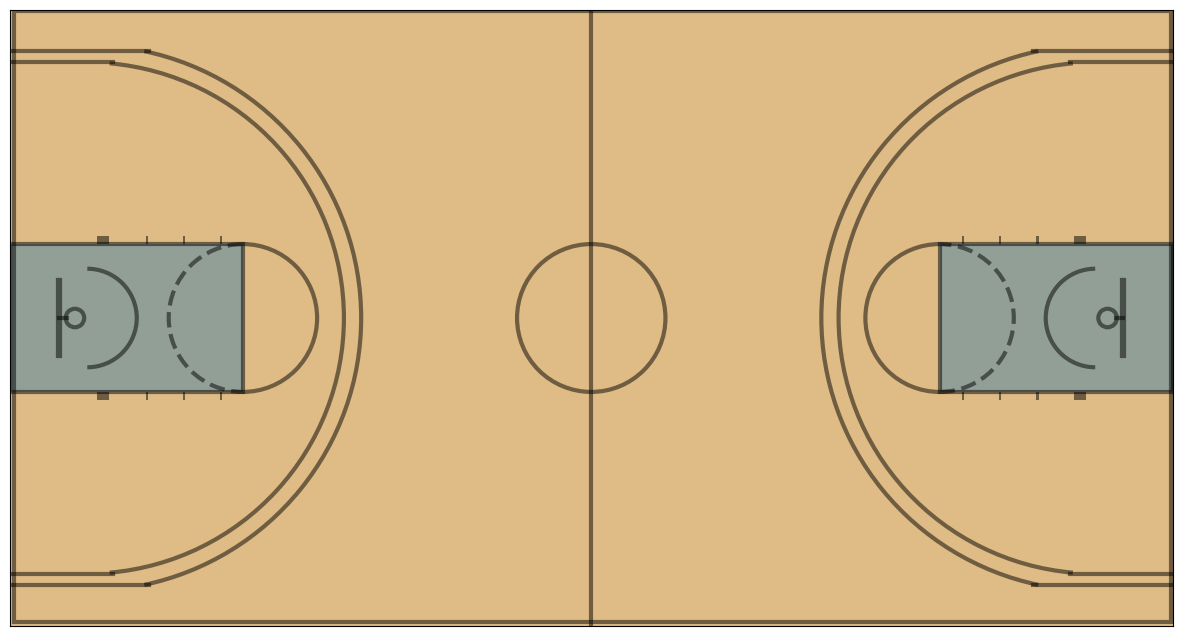

In [458]:
fig, ax = plt.subplots(figsize=(15, 8))
create_ncaa_full_court(ax,
                       three_line='both',
                       paint_alpha=0.4,
                       inner_arc=True)
plt.show()

C:\Users\632961\AppData\Local\Temp\ipykernel_19384\3985945241.py:5: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  filtered_data["Color"] = np.where(filtered_data["annotation_code"] == "s", "#f72323",\


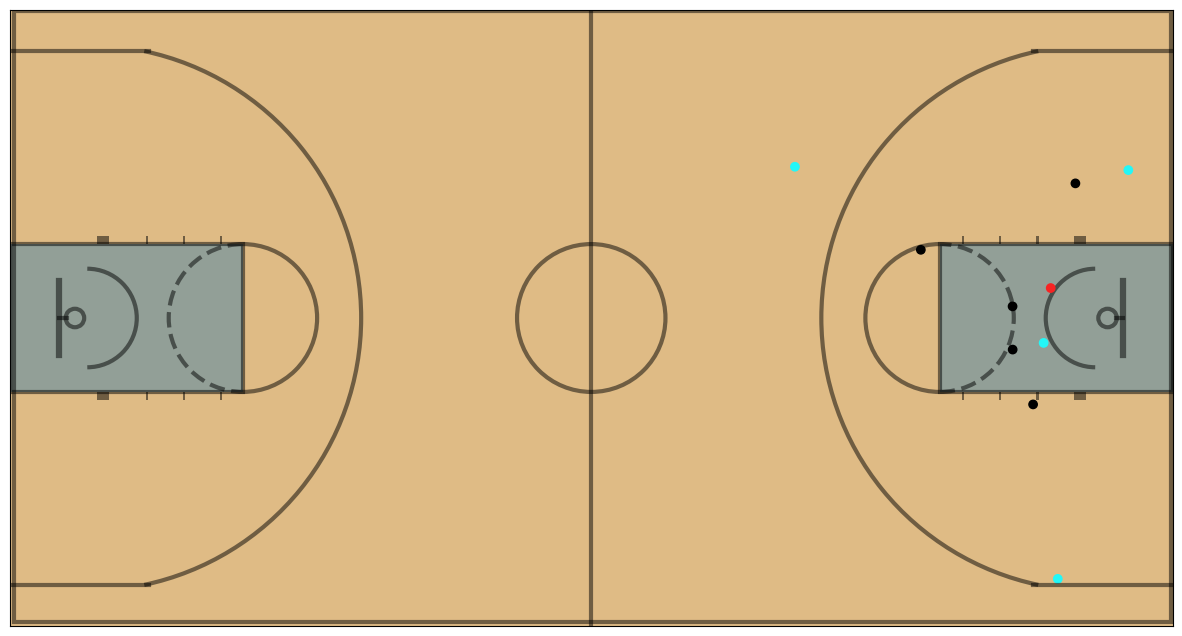

In [474]:
'''play = "1022-12"

filtered_data = plot_full[plot_full['id'] == play]

filtered_data["Color"] = np.where(filtered_data["annotation_code"] == "s", "#f72323",\
                                  np.where(filtered_data["annotation_code"].apply(lambda x: x[0]) == "t", "#23f7f7", "#000000"))


fig, ax = plt.subplots(figsize=(15, 8))
create_ncaa_full_court(ax,
                       three_line='mens',
                       paint_alpha=0.4,
                       inner_arc=True)


ax.scatter(filtered_data['court_x'], filtered_data['court_y'], c = filtered_data['Color'])

#ax.text(0, -5, filtered_data['is_oreb'][0], fontsize=30)

plt.show()'''


### Modelling

#### Linear Regression

In [467]:
"""lm = LinearRegression()

lm.fit(train_x, train_y)

coeff_df = pd.DataFrame(lm.coef_,train_x.columns,columns=['Coefficient']).sort_values('Coefficient')
print(coeff_df)

lmpredictions = lm.predict(test_x)

LMLogLoss = metrics.log_loss(test_y, lmpredictions)
print(LMLogLoss)"""

                           Coefficient

s_x                      -7.047543e+09

t2_x                     -7.047543e+09

t4_x                     -7.047543e+09

t3_x                     -7.047543e+09

t1_x                     -7.047543e+09

d3_x                     -5.040001e+09

d4_x                     -5.040001e+09

d5_x                     -5.040001e+09

d2_x                     -5.040001e+09

d1_x                     -5.040001e+09

DefenseWithin15ofRim     -1.371282e+09

OffenseAdvantage15ofRim  -1.371282e+09

OffenseWithin10ofRim     -3.348390e+08

OffenseAdvantage5ofRim   -3.156341e+08

DefenseWithin5ofRim      -3.156341e+08

AverageDefenseY          -2.415815e+08

OffenseWithin2ofRim      -1.591006e+08

AverageOffenseY          -4.000971e+07

OffenseWithin2ofShooter  -1.079231e-01

DefenseWithin15ofShooter -7.102795e-03

DefenseWithin2ofShooter  -2.225012e-03

DistanceOfShot            1.843438e-03

OffenseWithin15ofShooter  2.997674e-03

ClosestDefenderToShot     6.382337e-03



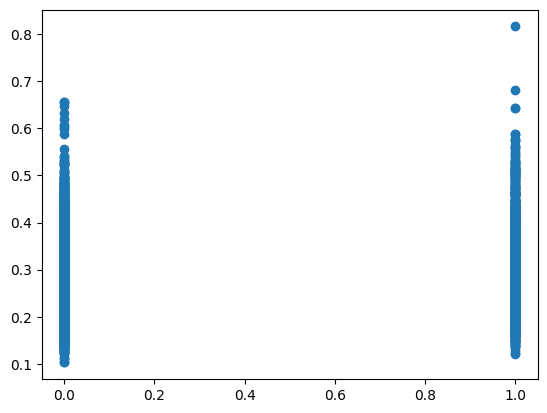

In [468]:
#plt.scatter(test_y,lmpredictions)
#plt.show()

#### Tree Based Models
Traditional Random Forest, XGBoost

In [154]:
"""from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


dtree = DecisionTreeClassifier()
dtree.fit(train_x,train_y)
dpredictions = dtree.predict(test_x)

dtreeLogLoss = metrics.log_loss(test_y, dpredictions)
print(dtreeLogLoss)



rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_x, train_y)
rpredictions = rfc.predict(test_x)

rfcLogLoss = metrics.log_loss(test_y, rpredictions)
print(rfcLogLoss)"""

14.667235585161254

10.556601404363866


In [469]:
'''from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


dtree = DecisionTreeRegressor()
dtree.fit(train_x,train_y)
dpredictions = dtree.predict(test_x)

dtreeLogLoss = metrics.log_loss(test_y, dpredictions)
print(dtreeLogLoss)



rfc = RandomForestRegressor(n_estimators=100)
rfc.fit(train_x, train_y)
rpredictions = rfc.predict(test_x)

rfcLogLoss = metrics.log_loss(test_y, rpredictions)
print(rfcLogLoss)'''

14.442641552625286

0.5842483403670223


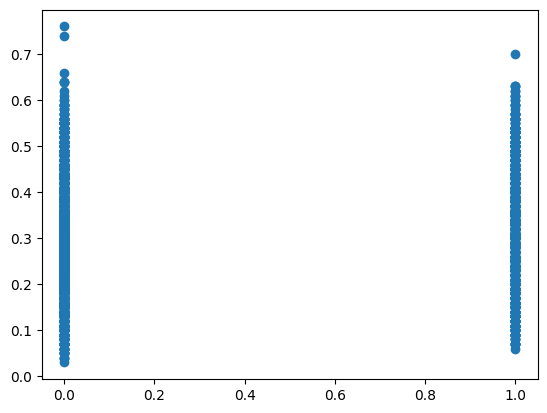

In [470]:
'''plt.scatter(test_y,rpredictions)
plt.show()'''

In [40]:
import xgboost as xgb

xgbooster = xgb.XGBRegressor()

clf = GridSearchCV(xgbooster, {'max_depth': [1, 2, 4, 6, 8, 10],
                            'n_estimators': [10, 25, 50, 100, 200, 500]}, verbose=1)
clf.fit(train_x, train_y)


xgbpredictions = clf.predict(test_x)

#xgbLogLoss = metrics.log_loss(test_y, xgbpredictions)
#print(xgbLogLoss)

""" xgboostec = xgb.XGBClassifier()

clfc = GridSearchCV(xgboostec, {'max_depth': [2, 4, 6],
                            'n_estimators': [50, 100, 200]}, verbose=1)
clfc.fit(train_x, train_y)


xgbcpredictions = clfc.predict(test_x)

xgbcLogLoss = metrics.log_loss(test_y, xgbcpredictions)
print(xgbcLogLoss)
 """

Fitting 5 folds for each of 36 candidates, totalling 180 fits


" xgboostec = xgb.XGBClassifier()\n\nclfc = GridSearchCV(xgboostec, {'max_depth': [2, 4, 6],\n                            'n_estimators': [50, 100, 200]}, verbose=1)\nclfc.fit(train_x, train_y)\n\n\nxgbcpredictions = clfc.predict(test_x)\n\nxgbcLogLoss = metrics.log_loss(test_y, xgbcpredictions)\nprint(xgbcLogLoss)\n "

XGBRegressor(base_score=None, booster=None, callbacks=None,

             colsample_bylevel=None, colsample_bynode=None,

             colsample_bytree=None, early_stopping_rounds=None,

             enable_categorical=False, eval_metric=None, feature_types=None,

             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,

             interaction_constraints=None, learning_rate=None, max_bin=None,

             max_cat_threshold=None, max_cat_to_onehot=None,

             max_delta_step=None, max_depth=1, max_leaves=None,

             min_child_weight=None, missing=nan, monotone_constraints=None,

             n_estimators=200, n_jobs=None, num_parallel_tree=None,

             predictor=None, random_state=None, ...)


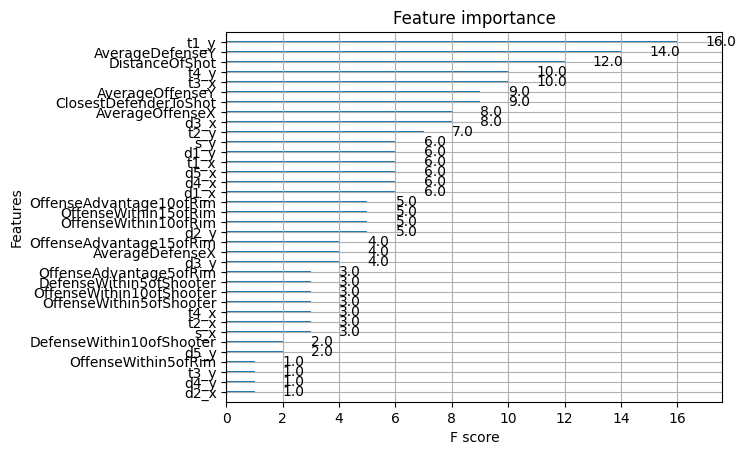

In [41]:
from xgboost import plot_importance

print(clf.best_estimator_)

plot_importance(clf.best_estimator_)
plt.show()


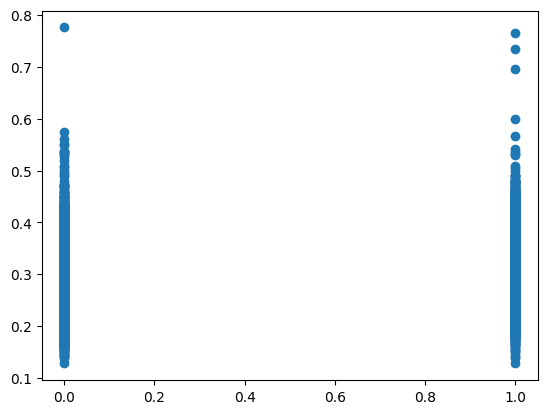

In [486]:
#plt.scatter(test_y,xgbpredictions)
#plt.show()

#### Support Vector Machines

In [163]:
'''from sklearn.svm import SVC

svc = SVC()

svc.fit(train_x, train_y)

svcpredictions = svc.predict(test_x)


svcLogLoss = metrics.log_loss(test_y, svcpredictions)
print(svcLogLoss)'''

10.450195342463115


In [ ]:
#print(classification_report(test_y,svcpredictions))

In [ ]:
#plt.scatter(test_y,svcpredictions)
#plt.show()

In [481]:
'''from sklearn.svm import SVR

svr = SVR()

svr.fit(train_x, train_y)

svrpredictions = svr.predict(test_x)


svrLogLoss = metrics.log_loss(test_y, svrpredictions)
print(svrLogLoss)'''

0.7046283738021956


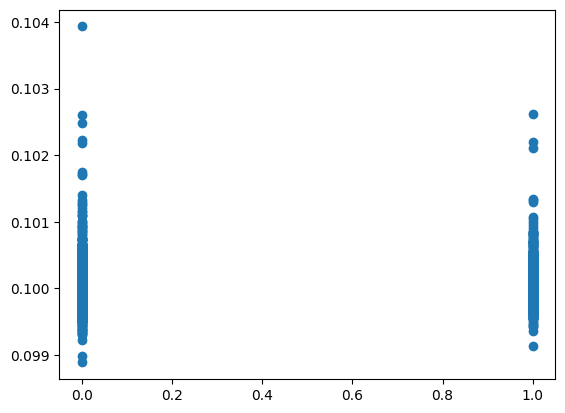

In [482]:
#plt.scatter(test_y,svrpredictions)
#plt.show()

#### Neural Network with a number of dense layers
Hyperparameter tuning is most of the work
Dropout layers,

Activation functions,

Adam optimizer,

learning rate

In [478]:
'''import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))
model.add(Dense(1, activation = "sigmoid"))

model.compile(
    loss="mse",
    optimizer=Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.CosineSimilarity(axis=1),tf.keras.metrics.LogCoshError(), "mse", "mae"]
)

model.fit(train_x, train_y, epochs=25)'''

Epoch 1/25

775/775 [==============================] - 3s 3ms/step - loss: 0.2060 - root_mean_squared_error: 0.4538 - cosine_similarity: 0.2842 - logcosh: 0.0970 - mse: 0.2060 - mae: 0.4072

Epoch 2/25

775/775 [==============================] - 2s 3ms/step - loss: 0.2038 - root_mean_squared_error: 0.4515 - cosine_similarity: 0.2842 - logcosh: 0.0961 - mse: 0.2038 - mae: 0.4063

Epoch 3/25

775/775 [==============================] - 2s 3ms/step - loss: 0.2025 - root_mean_squared_error: 0.4500 - cosine_similarity: 0.2842 - logcosh: 0.0955 - mse: 0.2025 - mae: 0.4046

Epoch 4/25

775/775 [==============================] - 2s 3ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493 - cosine_similarity: 0.2842 - logcosh: 0.0952 - mse: 0.2019 - mae: 0.4037

Epoch 5/25

775/775 [==============================] - 2s 3ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493 - cosine_similarity: 0.2842 - logcosh: 0.0952 - mse: 0.2019 - mae: 0.4037

Epoch 6/25

775/775 [========================

In [479]:
#NNpred = model.predict(test_x)


#NNLogLoss = metrics.log_loss(test_y, NNpred)
#print(NNLogLoss)

188/188 [==============================] - 0s 1ms/step

0.5743944565658106


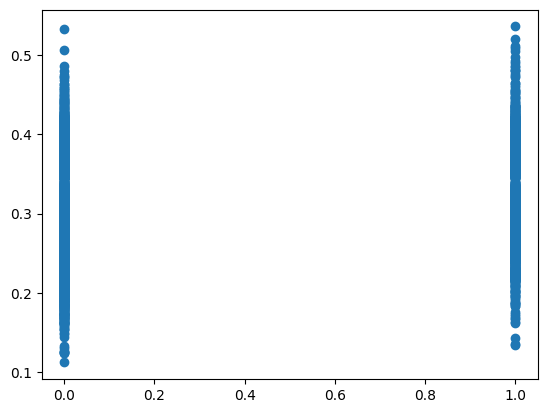

In [480]:
#plt.scatter(test_y,NNpred)
#plt.show()

### Output file

##### Best Results from XGBoost, Submission being made from there.

In [42]:
submission = pd.DataFrame(full_wide_test["id"])
submission["pred"] = xgbpredictions
submission.to_csv("Submission.csv", index = False)